Pattern and Anomaly Detection Lab Experiment 3

## Anomaly Detection using Bagging Feature and Isolation Forest

Reeha Parkar

IBM AIML Batch - AIML1

BE Electronics 

**60001180046**

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import sys
import datetime
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import IsolationForest

In [2]:
np.random.seed(20) # include a seed for reproducibility

# generate the normal data using number of points, 
# number of relevant features, mean and standard deviation
norm_pts = 5000
norm_dim = 5
norm_mean = 0.0
norm_stdev = 0.5
norm_data = np.random.normal(norm_mean, norm_stdev,(norm_pts, norm_dim))

# Note:
#
# Do not confuse the two uses of 'normal'
# The 'normal' in np.random.multivariate_normal refers 
# to a Gaussian distribution and is not related in general 
# to normal vs. anomaly 

In [3]:
# Generate Gaussian distribution for preliminary anomaly data
# using number of points, number of relevant features, 
# mean and standard deviation
anom_pts = 100
anom_dim = 5
anom_mean = 0.0
anom_stdev = 0.5
anom_data_prelim = np.random.normal(anom_mean, anom_stdev,(anom_pts, anom_dim))

In [4]:
# Transform into ring distribution for final anomaly data
def transform_to_ring(data, radius, spread):
    """
    Transforms the data provided into a ring distribution.
    ---
    Inputs: data (the data to be transformed, np.array),
    radius (radius of ring, float)
    spread (spread of data about radius, float)
    Outputs: transformed_data (np.array)
    """
    transformed_data_list = []
    for item in data:
        z = np.array(item) # in case data is provided as list
        transformed_data_list.append(z*spread+ radius*z / np.linalg.norm(z))
        transformed_data = np.array(transformed_data_list)
    return transformed_data


In [5]:
anom_data = transform_to_ring(anom_data_prelim, 2.0, 1.0)
len(anom_data)

100

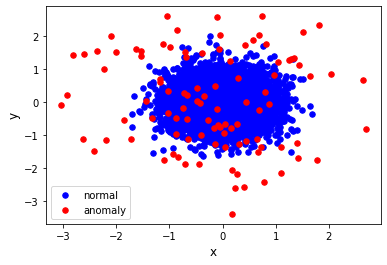

In [6]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)

ax1.scatter(norm_data[:,0], norm_data[:,1], s=30, c='b', marker="o", label='normal')
ax1.scatter(anom_data[:,0], anom_data[:,1], s=30, c='r', marker="o", label='anomaly')
plt.legend(loc='best');
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

In [7]:
combined_data = np.concatenate((norm_data, anom_data), axis=0)
combined_data.shape

(5100, 5)

In [8]:
noise_dim = 5
noise_mean = 0
noise_stdev = 4
noise_norm = np.random.normal(noise_mean, noise_stdev,(norm_pts, noise_dim))
noise_anom = np.random.normal(noise_mean, noise_stdev,(anom_pts, noise_dim ))

In [9]:
norm_data_full = np.concatenate((norm_data, noise_norm), axis=1)
anom_data_full = np.concatenate((anom_data, noise_anom), axis=1)
print(norm_data_full.shape)
print(anom_data_full.shape)

(5000, 10)
(100, 10)


In [10]:
all_data = np.concatenate((norm_data_full, anom_data_full), axis=0)
all_data.shape

(5100, 10)

# Feature Bagging

In [12]:
def feature_bagging(data):
    """
    Selects subspace data using feature bagging.
   
    Args: 
        data: the full data to be sampled (np.array)
        
    Returns: 
        subspace_data: the subspace data (np.array)
    """
    # Find the size of the full dimensional space
    full_dim = data.shape[1]
    # select size of subspace
    size_subspace = np.random.randint(full_dim // 2, full_dim - 1)
    # select features without replacement 
    subspace_index = np.random.choice(full_dim, size_subspace, replace=False)
    # select subspace data 
    # Originally, features are data columns
    # Transponse to select features as rows (easier)
    # and then transponse back to restore features as columns
    subspace_data = (data.T[sorted(subspace_index),:]).T
    return subspace_data

### Subspace Method

In [13]:
def anomaly_subspace_method(data, repeat): #number of times of division will be repeated
    """
    Carries out anomaly detection using feature bagging.
    Uses Local Outlier Factor (LOF) for anomaly detection.
    Uses cumulative-sum approach to combine anomaly detection scores. 
    from each iteration
    
    Args: 
        data: the full data to be sampled (np.array)
        repeat: number of iterations for feature bagging (int)
    Returns:
        final_scores: the anomaly score of each point in the data (list)
    """
    #calculating anomaly score based on final score
    final_scores = np.zeros(len(data))
    for i in range(repeat):
        subspace_data = feature_bagging(data) #dividing data based on feature bagging algorithm
        clf = LocalOutlierFactor(n_neighbors=20, metric='manhattan') #calculate local outlier using k nearing neighbour 
        y_pred = clf.fit_predict(subspace_data)  #predicted value
        X_scores = clf.negative_outlier_factor_  #values having an anomaly will have higher negative values
        final_scores += X_scores                  #all x scores will be appended to final score
    return final_scores

In [14]:
cumulative_scores = anomaly_subspace_method(all_data, 10)
#10 is the number of times actual data i.e all_data needs to be divided 

In [15]:
print(cumulative_scores[0:20]) # printing first 20

[-10.42822032 -10.11430337  -9.94264351  -9.97740891 -11.35658359
 -10.65692172 -10.59557416 -11.89593756 -10.3129885  -10.14233905
 -12.02322703 -10.52378682 -10.10541638 -10.96957967 -10.63905103
 -10.36021459  -9.92217649 -10.67933135 -10.98069907 -11.39922243]


In [16]:
print(cumulative_scores[5080:5100]) # printing last 20 which have an anomaly according to data

[-14.85215851 -14.21291428 -15.21692821 -15.68583487 -16.28738734
 -15.99495715 -16.38737843 -14.46308237 -14.99386485 -16.59273306
 -11.95628822 -15.18960334 -15.72579168 -14.53332571 -22.4328569
 -15.98863141 -14.32595071 -14.94775829 -15.18901059 -14.30024492]


In [17]:
# It is not necessary that anomaly data will be present at the end will be anomaly or data at the beginning will be normal hence we implement the following

In [18]:
# sorting algorithm
ranking_by_index = np.argsort(cumulative_scores) #ranking acording to top most element, i.e higher negative value first and so on

In [19]:
print(ranking_by_index[0:20]) #printing top 20 have the highest negative value in order 

[5094 5028 5067 5079 5052 5054 5062 5077 5050 5089 5006 5020 1128 5009
 5053 5086 5084 5048 5016 5042]


In [20]:
print(ranking_by_index[0:40])

[5094 5028 5067 5079 5052 5054 5062 5077 5050 5089 5006 5020 1128 5009
 5053 5086 5084 5048 5016 5042 5001 5029 5043 5085 5095 3422 5060 5038
 5074 5025 5092 5024 5083 5008 5005 5061 5033 5051 5076 5017]


In [21]:
# Out of 40 points, 2 point are the anomaly (below 5000 i.e 1128 and 3422)

In [22]:
# Create labels based on known data
# We know that the first *norm_pts* are normal data (0)
# and the next *anom_pts* are anomalies (1)
label_true = [0]*norm_pts
print(len(label_true))
for i in range(anom_pts):
        label_true.append(1)
print(len(label_true))

5000
5100


In [23]:
label_pred = [0]*len(all_data)
for index, item in enumerate(ranking_by_index):
    label_pred[item] = 1
    if index == anom_pts:
        # We stop once we have label *anom_pts* points 
        break

In [24]:
#calculating confusion matrix
label_true_series = pd.Series(label_true, name='True')
label_pred_series = pd.Series(label_pred, name='Predicted')
df_confusion_matrix = pd.crosstab(label_true_series, label_pred_series)
df_confusion_matrix

Predicted,0,1
True,,
0,4985,15
1,14,86


In [25]:
# Out of 5100 points, 4985 normal were predicted, and 86 out of 100 anomaly points were predicted correctly

In [26]:
confusion_matrix(label_true, label_pred)

array([[4985,   15],
       [  14,   86]])

In [27]:
accuracy_score(label_true, label_pred)

0.994313725490196

In [28]:
# Confirming the above obtained result with IsolationForest

In [29]:
isolation_forest = IsolationForest(n_estimators=100, max_samples=256, contamination=0.01961, max_features=10) 
# contamination is (anomaly pts/total no. of points) i.e 100/5100

In [30]:
isolation_forest.fit(all_data)
anomaly_score = isolation_forest.decision_function(all_data)

In [31]:
print(anomaly_score[0:20])

[0.11709204 0.1128159  0.13177338 0.13714886 0.07200826 0.08519496
 0.04784857 0.05821061 0.06748824 0.11306076 0.04558373 0.09645274
 0.11755097 0.06819345 0.06142693 0.08882511 0.15169793 0.09186298
 0.07999592 0.05882143]


In [32]:
# The anomaly score for the first 20 points is close to zero

In [33]:
print(anomaly_score[5080:5100])

[-0.04777688 -0.04418608 -0.01611999 -0.06212357 -0.07933462 -0.02386272
  0.00986377  0.01580545  0.04366959 -0.08361305  0.02765042 -0.02287911
  0.01593167  0.00914116 -0.09425714  0.00650565  0.02878218  0.01659102
  0.00461355  0.05373863]


In [34]:
# The anomaly score for last 20 points are negative. Negative anomaly score indicates there is an anomaly at that point 

In [35]:
print(anomaly_score[5040:5100])

[ 0.03410114  0.00093158 -0.04800792 -0.04873228 -0.05823913 -0.03294734
  0.02655081  0.00407535  0.00347841 -0.02176965 -0.03966842 -0.05271227
 -0.03719579  0.01081625  0.0170258  -0.0271389  -0.0022058  -0.03381634
  0.05015335 -0.01992074 -0.03455719 -0.06372533 -0.07155021 -0.03152303
 -0.04112875  0.01804249  0.01353958 -0.03943952 -0.00640041 -0.02491554
  0.07450652 -0.03107066  0.00485212  0.05148618  0.05329564  0.04485056
 -0.05608973 -0.0815347   0.02208566 -0.06603552 -0.04777688 -0.04418608
 -0.01611999 -0.06212357 -0.07933462 -0.02386272  0.00986377  0.01580545
  0.04366959 -0.08361305  0.02765042 -0.02287911  0.01593167  0.00914116
 -0.09425714  0.00650565  0.02878218  0.01659102  0.00461355  0.05373863]


In [36]:
pred_forest = isolation_forest.predict(all_data)

In [37]:
print(pred_forest[5000:5100]) # will give -1 to the points who have an anomaly and 1 to the points without an anomaly

[-1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1  1
 -1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1  1  1 -1 -1 -1 -1  1  1
  1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1
  1  1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1  1
  1  1  1  1]


In [38]:
print(pred_forest[0:100])

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1 -1]


In [39]:
label_pred_forest = pred_forest
# normal data label switched from 1 to 0
label_pred_forest [label_pred_forest > 0] = 0 
# anomaly label switched from -1 to 1
label_pred_forest [label_pred_forest < 0] = 1 

In [40]:
accuracy_score(label_true, label_pred_forest) #accuracy

0.9847058823529412

In [41]:
# The accuracy for bagging feature is better, but for faster anomaly detection Isolation Forest would be the pick